In [1]:
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#define amount of sample points
N = 2000

In [3]:
def thermal_conductivity_equation(t, x):
    return (2 + torch.exp(-4*(torch.pi**2)*t)*torch.sin(2*torch.pi*x) + torch.exp(-16*(torch.pi**2)*t)*torch.cos(4*torch.pi*x))

# function depicting a real graph and a predicted one
def check_current_situation(cur_model):
    x = torch.linspace(0, 1, 100)
    time = torch.zeros(100)
    real_temp = thermal_conductivity_equation(time, x)

    test_points = torch.stack((x, time), axis = -1)

    pinn_temp = cur_model(test_points)

    plt.plot(x.detach(), pinn_temp.detach())
    plt.plot(x, real_temp)

    plt.plot()
    plt.show()

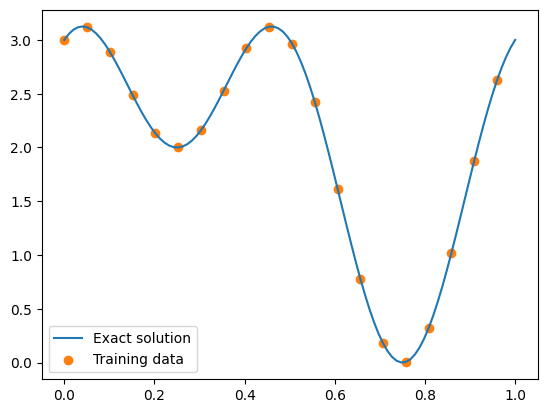

In [4]:
x = torch.linspace(0, 1, 100)
time = torch.zeros(100)
temp = thermal_conductivity_equation(time, x)

x_data = x[0:100:5]
temp_data = temp[0:100:5]


plt.plot(x, temp, label="Exact solution")
plt.scatter(x_data, temp_data, color="tab:orange", label="Training data")

plt.legend()
plt.show()

In [5]:
x_physics = torch.rand(N).view(-1, 1).requires_grad_(True)
time_physics = 0.05 * torch.rand(N).view(-1, 1).requires_grad_(True)

points_for_pinn_model = torch.stack((time_physics, x_physics), -1)
boundary_condition_points = torch.stack((torch.zeros(N), x_physics[:,0]), -1).unsqueeze(0)

torch.manual_seed(123)

In [6]:
#define the class PINN
class PINN(nn.Module):
    def __init__(self, input_layer = 2, hidden_layer = 32, number_layers = 3, output_layer = 1):
        super().__init__()
        
        activation = nn.Tanh
        
        self.fcs = nn.Sequential(*
            [
                nn.Linear(input_layer, hidden_layer),
                activation()
            ]
        )
        
        self.fch = nn.Sequential(*
            [
                nn.Sequential(*
                    [
                        nn.Linear(hidden_layer, hidden_layer),
                        activation()
                    ]
                ) for _ in range(number_layers - 1)
            ]
        )
        
        self.fce = nn.Linear(hidden_layer, output_layer)
        
        
    def forward(self, x):
        x = F.gelu(self.fcs(x))
        x = F.gelu(self.fch(x))
        x = F.gelu(self.fce(x))
        
        return x

In [7]:
pinn_model = PINN()
# optimizer = torch.optim.SGD(pinn_model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(pinn_model.parameters(), lr = 0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5000, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor = 0.7)

epoch: 0, loss: 9.400304794311523, learning_rate: 0.001


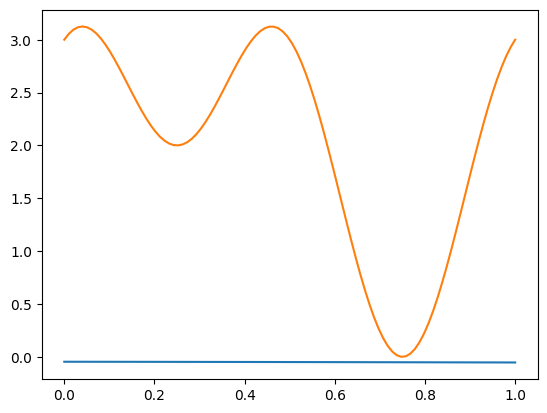

epoch: 250, loss: 1.152023434638977, learning_rate: 0.001
epoch: 500, loss: 0.9144942760467529, learning_rate: 0.001
epoch: 750, loss: 0.8852136135101318, learning_rate: 0.001
epoch: 1000, loss: 0.8693061470985413, learning_rate: 0.001


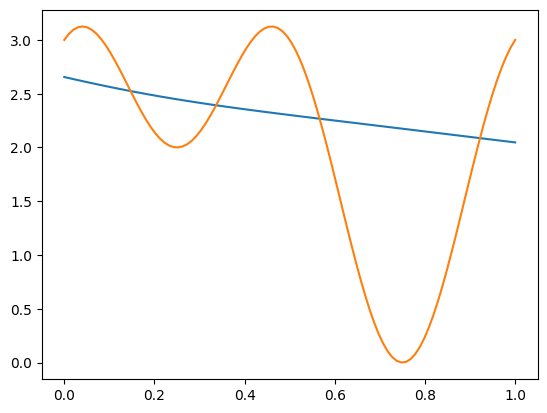

epoch: 1250, loss: 0.8615807294845581, learning_rate: 0.001
epoch: 1500, loss: 0.8551150560379028, learning_rate: 0.001
epoch: 1750, loss: 0.8486961126327515, learning_rate: 0.001
epoch: 2000, loss: 0.8411537408828735, learning_rate: 0.001


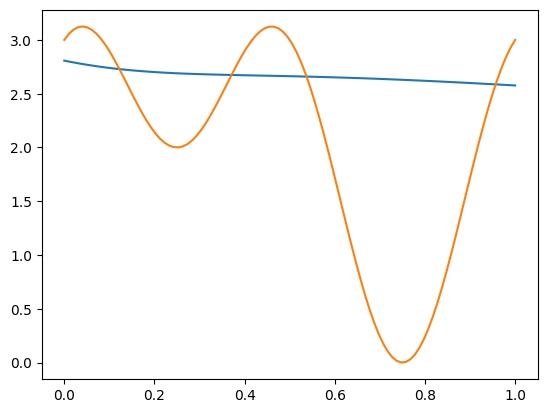

epoch: 2250, loss: 0.8294792771339417, learning_rate: 0.001
epoch: 2500, loss: 0.8176211714744568, learning_rate: 0.001
epoch: 2750, loss: 0.8092848062515259, learning_rate: 0.001
epoch: 3000, loss: 0.7996677756309509, learning_rate: 0.001


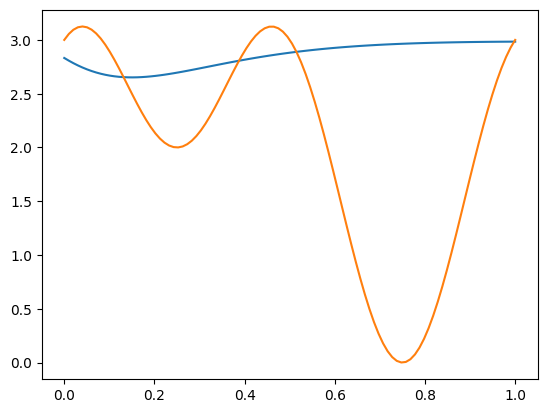

epoch: 3250, loss: 0.7953140139579773, learning_rate: 0.001
epoch: 3500, loss: 0.7732699513435364, learning_rate: 0.001
epoch: 3750, loss: 0.7532938718795776, learning_rate: 0.001
epoch: 4000, loss: 0.7374875545501709, learning_rate: 0.001


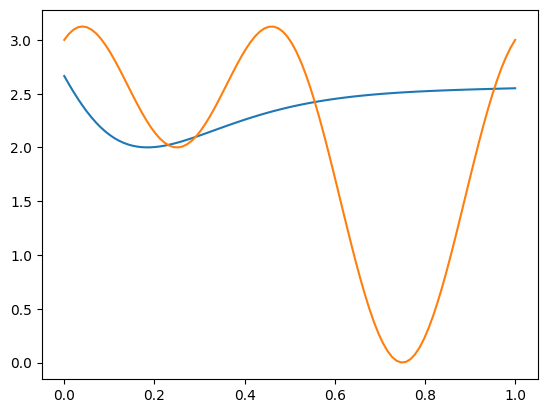

epoch: 4250, loss: 0.7301365733146667, learning_rate: 0.001
epoch: 4500, loss: 0.7129834294319153, learning_rate: 0.001
epoch: 4750, loss: 0.7056080102920532, learning_rate: 0.001


In [ ]:
epochs = 20000


for cur_epoch in range(epochs):
    optimizer.zero_grad()
    
    boundary_condition_temp = pinn_model.forward(boundary_condition_points)
    
    # compute the "data loss"
    loss1 = torch.mean((thermal_conductivity_equation(time_physics, x_physics) - boundary_condition_temp)**2)
    loss2 = torch.mean((thermal_conductivity_equation(torch.zeros_like(x_physics), x_physics) - boundary_condition_temp)**2)
    
    network_temp = pinn_model.forward(points_for_pinn_model)
    
    dt = torch.autograd.grad(network_temp, time_physics, torch.ones_like(network_temp), create_graph=True)[0]

    # computes dy/dx
    dx = torch.autograd.grad(network_temp, x_physics, torch.ones_like(network_temp), create_graph=True)[0]
    
    # computes d^2y/dx^2
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]
    
    # compute the "physics loss"
    loss3 = torch.mean((dt - dx2)**2)
    
    
    loss = loss1 + loss2 + loss3
    loss.backward(retain_graph=True)
    
    optimizer.step()
#     scheduler.step(loss)
#     optimizer.param_groups[0]['lr'] = max(0.0001, optimizer.param_groups[0]['lr'])
    
    
    if cur_epoch % 250 == 0:
        print(f'epoch: {cur_epoch}, loss: {loss}, learning_rate: {optimizer.param_groups[0]["lr"]}')
    if cur_epoch % 1000 == 0:
        check_current_situation(pinn_model)
        
    
print(f'epoch: {cur_epoch}, loss: {loss}, learning_rate: {optimizer.param_groups[0]["lr"]}')
check_current_situation(pinn_model)   